![image](https://docs.google.com/uc?export=download&id=1Nh6vjig-ADM1RMbaHrj_GItD3O1ZW4Vr)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4206_Analisis_con_Machine_Learning/blob/main/Lab%20IV/Lab_IV.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

# **Taller No. 4**
## **Regresión Logística y Entrenamiento Desbalanceado**

## **Objetivos**
- Aprender a utilizar la regresión logística como modelo de clasificación.
- Introducción al aprendizaje por datos desbalanceados con Oversampling y Undersampling.
- Balancear datos durante el modelado a través de ponderación.

## **Nombres de los Integrantes**
- **Integrante 1**: Diego Alejandro Peña Bernal - 200814497
- **Integrante 2**: Alveiro García Niño - 202022910
- **Integrante 3**: N/A

## **Problema 1**
- Los peligros asociados a la minería de carbón son bastantes, desde enfermedades pulmonares hasta explosiones por combustión. Sin embargo, uno bastante común es el peligro sísmico. Los peligros sísmicos se resumen como la probabilidad de que un terremoto vaya a ocurrir en un área geográfica determinada. Por lo que, se le ha asignado la tarea de predecir la posibilidad de que un peligro sísmico ocurra en un área específica dadas sus condiciones geográficas.

In [ ]:
%%shell
shred -u setup_colab_general.py
wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
pip install -q tqdm==4.56.0
pip install -q --upgrade imbalanced-learn

shred: setup_colab_general.py: failed to open for writing: No such file or directory
     - 38.3MB 122.3MB/s
     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 1.1MB 14.5MB/s 
     |████████████████████████████████| 3.2MB 33.9MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 296kB 45.2MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.4.1 which is incompatible.
     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 215kB 8.6MB/s 
     |████████████████████████████████| 22.3MB 1.3MB/s 


In [ ]:
import setup_colab_general as setup_general
setup_general.setup_general()

  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [ ]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
rcParams['figure.figsize'] = 14, 7

from utils import general as gen

from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, recall_score, 
                             precision_score, f1_score, confusion_matrix)

In [ ]:
data_id = "19-2ZJXc3bUY_AmpzdfneCyPWF73wsuXw"

In [ ]:
gen.download_file_from_google_drive(data_id, "data.csv", size=131)

  0%|          | 0/131 [00:00<?, ?KB/s]

In [ ]:
dataframe = pd.read_csv("data/data.csv")

In [ ]:
dataframe.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


## **Separación y Perfilamiento**
- El dataset consta de 19 columnas y 2584 filas. Las columnas y su respectivo diccionario son los siguientes:
    - seismic: Resultado de la evaluación del peligro sísmico por desplazamiento obtenida por el método sísmico. Sus variables son: a (ausencia de peligro), b (bajo riesgo), c (alto peligro) y d (estado de peligro).
    - seismoacoustic: Resultado de la evaluación de la amenaza sísmica por turnos obtenida mediante el método sismoacústico.
    - shift: Tipo de turnos w (obtención de carbón), n (turno de preparación)
    - genergy: Energía sísmica registrada dentro del cambio anterior por el geófono más activo de todos los geófonos que monitorean la pared larga.
    - gpuls: Número de pulsos registrados en el turno anterior por el geófono más activo.
    - gdenergy: Una desviación de la energía registrada dentro del turno anterior por el geófono más activo, de la energía promedio registrada durante los ocho turnos anteriores.
    - gdpuls: Una desviación de un número de pulsos registrados dentro del turno anterior por GMax del número promedio.
    - ghazard: resultado de la evaluación del peligro sísmico por turnos en el trabajo de la mina obtenido por el método sismoacústico basado en el registro proveniente de GMax solamente.
    - energy: energía total de los golpes sísmicos registrados en el turno anterior.
    - maxenergy: la energía máxima de los golpes sísmicos registrados en el turno anterior.
    - nbumps : el número de golpes sísmicos registrados en el turno anterior.
    - nbumps2 : el número de golpes sísmicos (en el rango de energía [10 ^ 2,10 ^ 3)) registrados en el turno anterior.
    - nbumps3 : el número de golpes sísmicos (en el rango de energía [10 ^ 3,10 ^ 4)) registrados en el turno anterior.
    - nbumps4 : el número de golpes sísmicos (en el rango de energía [10 ^ 4,10 ^ 5)) registrados en el turno anterior.
    - nbumps5 : el número de golpes sísmicos (en el rango de energía [10 ^ 5,10 ^ 6)) registrados en el turno anterior.
    - nbumps6 : el número de golpes sísmicos (en el rango de energía [10 ^ 6,10 ^ 7)) registrados en el turno anterior.
    - nbumps7 : el número de golpes sísmicos (en el rango de energía [10 ^ 7,10 ^ 8)) registrados en el turno anterior.
    - nbumps89 : el número de golpes sísmicos (en el rango de energía [10 ^ 8,10 ^ 10)) registrados en el turno anterior.


In [ ]:
X = dataframe.drop("class", axis=1)
y = dataframe["class"]

In [ ]:
stratified_splitter = StratifiedShuffleSplit(test_size=0.3, random_state=1234)

In [ ]:
for full_train_index, test_index in stratified_splitter.split(X, y):
    full_X_train, full_y_train = X.iloc[full_train_index], y.iloc[full_train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

In [ ]:
stratified_splitter = StratifiedShuffleSplit(test_size=0.3, random_state=5678)

In [ ]:
for train_index, val_index in stratified_splitter.split(full_X_train, full_y_train):
    X_train, y_train = full_X_train.iloc[train_index], full_y_train.iloc[train_index]
    X_val, y_val = full_X_train.iloc[val_index], full_y_train.iloc[val_index]

In [ ]:
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
pandas_profiling.ProfileReport(X_train, minimal=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   seismic         1265 non-null   object
 1   seismoacoustic  1265 non-null   object
 2   shift           1265 non-null   object
 3   genergy         1265 non-null   int64 
 4   gpuls           1265 non-null   int64 
 5   gdenergy        1265 non-null   int64 
 6   gdpuls          1265 non-null   int64 
 7   hazard          1265 non-null   object
 8   nbumps          1265 non-null   int64 
 9   nbumps2         1265 non-null   int64 
 10  nbumps3         1265 non-null   int64 
 11  nbumps4         1265 non-null   int64 
 12  nbumps5         1265 non-null   int64 
 13  nbumps6         1265 non-null   int64 
 14  nbumps7         1265 non-null   int64 
 15  nbumps89        1265 non-null   int64 
 16  energy          1265 non-null   int64 
 17  maxenergy       1265 non-null   int64 
dtypes: int64

In [ ]:
X_train.describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy
count,1.265000e+03,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.000000,1265.0,1265.0,1265.0,1265.000000,1265.000000
mean,8.511620e+04,527.474308,13.513834,4.777075,0.858498,0.381818,0.401581,0.069565,0.005534,0.0,0.0,0.0,5466.166008,4738.023715
std,1.995497e+05,520.914791,79.270866,61.269205,1.340600,0.782817,0.771320,0.283901,0.074211,0.0,0.0,0.0,22293.923576,21089.557022
min,4.300000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,1.180000e+04,189.000000,-38.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
50%,2.546000e+04,381.000000,-5.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
75%,5.141000e+04,660.000000,41.000000,29.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,3000.000000,2000.000000
max,1.661100e+06,3510.000000,681.000000,367.000000,9.000000,8.000000,5.000000,3.000000,1.000000,0.0,0.0,0.0,303000.000000,300000.000000


In [ ]:
y_train.unique()

array([0, 1])

In [ ]:
y_train.mean(), 1 - y_train.mean()

(0.06561264822134387, 0.9343873517786562)

In [ ]:
y_val.mean(), 1 - y_val.mean()

(0.06629834254143646, 0.9337016574585635)

In [ ]:
y_test.mean(), 1 - y_test.mean()

(0.06572164948453608, 0.9342783505154639)

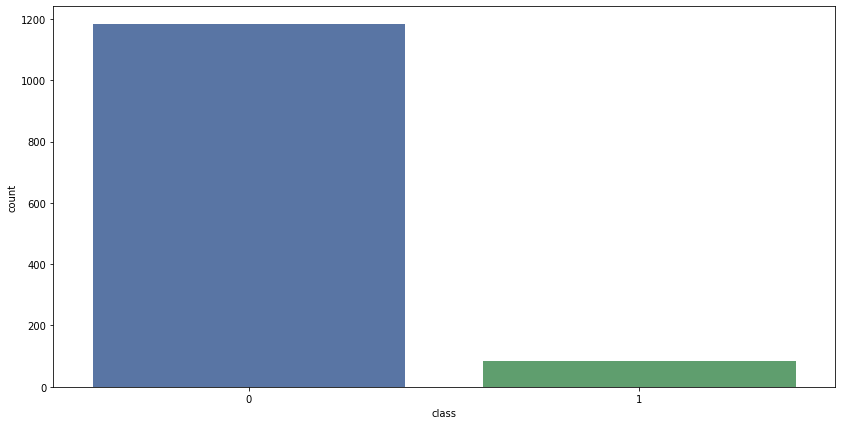

In [ ]:
sns.countplot(x=y_train)
plt.show()

## **Procesamiento y Limpieza**

In [ ]:
def pipeline(data):
    data_copy = data.copy()
    label_encoder = LabelEncoder()

    for col_name, col in data_copy.iteritems():
        if col.dtype == "object":
            data_copy[col_name] = label_encoder.fit_transform(col)

    variance_threshold = VarianceThreshold()
    data_copy = variance_threshold.fit_transform(data_copy)
    
    min_max_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    negative_indexes = list()
    positive_indexes = list()
    for col_index in range(data_copy[0].size):
        if np.unique(data_copy[:, col_index]).size >= 20:
            if data_copy[:, col_index].min() < 0:
                negative_indexes.append(col_index)
            else:
                positive_indexes.append(col_index)
    data_copy[:, negative_indexes] = standard_scaler.fit_transform(
        data_copy[:, negative_indexes]
    )
    data_copy[:, positive_indexes] = min_max_scaler.fit_transform(
        data_copy[:, positive_indexes]
    )
    return data_copy

In [ ]:
X_train_transformed = pipeline(X_train)

In [ ]:
X_train.shape

(1265, 18)

In [ ]:
X_train_transformed.shape

(1265, 15)

## **Modelado**
### **Sin Remuestreo**

In [ ]:
log_reg = LogisticRegression().fit(X_train_transformed, y_train)

In [ ]:
X_val_transformed = pipeline(X_val)

In [ ]:
y_pred = log_reg.predict(X_val_transformed)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       507
           1       0.00      0.00      0.00        36

    accuracy                           0.93       543
   macro avg       0.47      0.50      0.48       543
weighted avg       0.87      0.93      0.90       543



In [ ]:
f1_score(y_val, y_pred)

0.0

### **Oversampling**
- SMOTE

In [ ]:
resampler = SMOTE(random_state=1234, sampling_strategy=0.5)

In [ ]:
X_train_resampled, y_train_resampled = resampler.fit_resample(
    X_train_transformed, y_train
)

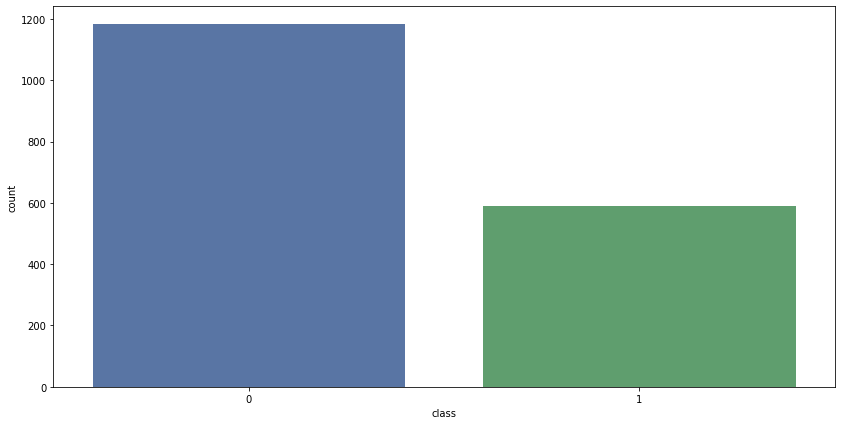

In [ ]:
sns.countplot(x=y_train_resampled)
plt.show()

In [ ]:
X_train_resampled.shape

(1773, 15)

In [ ]:
y_train_resampled.shape

(1773,)

In [ ]:
log_reg = LogisticRegression().fit(X_train_resampled, y_train_resampled)

In [ ]:
X_val_resampled, y_val_resampled = resampler.fit_resample(X_val_transformed, y_val)

In [ ]:
y_pred = log_reg.predict(X_val_transformed)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       507
           1       0.26      0.42      0.32        36

    accuracy                           0.88       543
   macro avg       0.61      0.67      0.63       543
weighted avg       0.91      0.88      0.90       543



In [ ]:
f1_score(y_val, y_pred)

0.3225806451612903

### **Subsampling**

In [ ]:
resampler = RandomUnderSampler(random_state=1234, sampling_strategy=0.3)

In [ ]:
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_transformed, y_train)

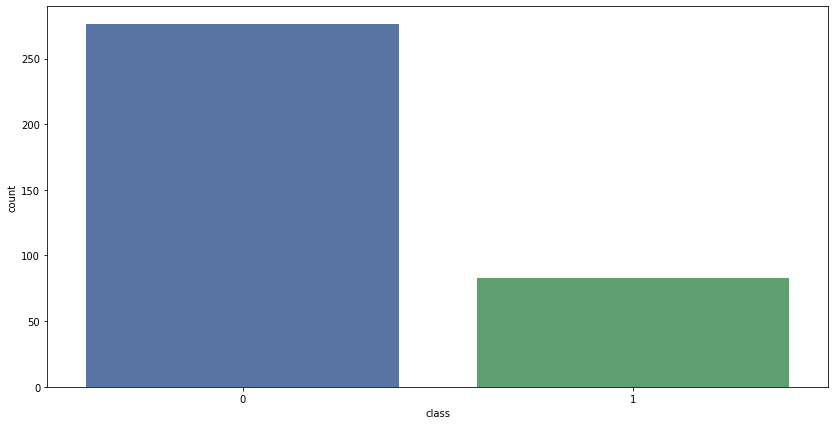

In [ ]:
sns.countplot(x=y_train_resampled)
plt.show()

In [ ]:
X_train_resampled.shape

(359, 15)

In [ ]:
y_train_resampled.shape

(359,)

In [ ]:
log_reg = LogisticRegression().fit(X_train_resampled, y_train_resampled)

In [ ]:
y_pred = log_reg.predict(X_val_transformed)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       507
           1       0.29      0.33      0.31        36

    accuracy                           0.90       543
   macro avg       0.62      0.64      0.63       543
weighted avg       0.91      0.90      0.91       543



In [ ]:
f1_score(y_val, y_pred)

0.3116883116883117

### **Balanceo en el Modelado**

In [ ]:
LogisticRegression?

In [ ]:
log_reg = LogisticRegression(class_weight="balanced").fit(
    X_train_transformed, y_train
)

In [ ]:
y_pred = log_reg.predict(X_val_transformed)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       507
           1       0.16      0.75      0.26        36

    accuracy                           0.72       543
   macro avg       0.57      0.73      0.54       543
weighted avg       0.92      0.72      0.79       543



In [ ]:
f1_score(y_val, y_pred)

0.2608695652173913

## **Validación**

In [ ]:
resampler = SMOTE(random_state=1234, sampling_strategy=0.5)

In [ ]:
X_train_resampled, y_train_resampled = resampler.fit_resample(
    X_train_transformed, y_train
)

In [ ]:
X_train_resampled.shape

(1773, 15)

In [ ]:
log_reg = LogisticRegression().fit(X_train_resampled, y_train_resampled)

In [ ]:
X_test_transformed = pipeline(X_test)

In [ ]:
y_pred = log_reg.predict(X_test_transformed)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       725
           1       0.23      0.35      0.27        51

    accuracy                           0.88       776
   macro avg       0.59      0.63      0.60       776
weighted avg       0.90      0.88      0.89       776



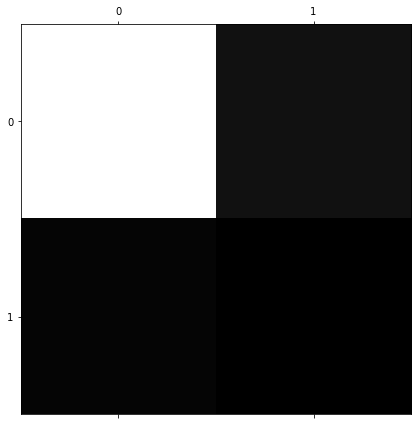

In [ ]:
plt.matshow(confusion_matrix(y_test, y_pred), cmap="gray");

In [ ]:
f1_score(y_test, y_pred)

0.2748091603053435

## **Ejercicios**
- El infarto de miocardio está estrechamente relacionado con factores de estrés crónico y una nutrición irregular y no siempre equilibrada. El curso de la enfermedad en pacientes con infarto de miocardio es diferente. Puede ocurrir sin complicaciones o con complicaciones que no empeoran el pronóstico a largo plazo. Pero también, aproximadamente la mitad de los pacientes en los períodos agudo y subagudo tienen complicaciones que conducen al empeoramiento de la enfermedad e incluso a la muerte. En muchos casos un especialista experimentado no siempre puede prever el desarrollo de estas complicaciones. En este sentido, construir modelos con aprendizaje automático que ayuden a predecir las complicaciones del infarto de miocardio puede apoyar la toma decisiones en cuanto a las medidas preventivas a aplicar. El conjunto de datos a utilizar para el estudio se encuentra en el siguiente [enlace](https://drive.google.com/file/d/1wMqUCQ3_q1InDS0coW-s6J5Rct8WK9iQ/view?usp=sharing).
Las variables de las columnas 113 a 124 representan posibles complicaciones. En esta etapa inicial del estudio los expertos se quieren enfocar en la complicación relacionada con “Falla de corazón crónica” (Chronic heart failure, ZSN). Además, han hecho sugerencias sobre cómo tratar las ausencias. Recomiendan eliminar los atributos con más de 10% de ausencias en primera instancia. Luego, aplicar una eliminación de registros.
Construya este modelo de predicción utilizando una máquina de vectores de soporte. Como los datos no están balanceadas, aplique las tres técnicas vistas en este laboratorio y compare los resultados. Finalmente, para los modelos resultantes de estas tres técnicas, construya una curva ROC para cada uno y grafique dentro de la misma imagen.

In [3]:
# Importing the libraries that will be used
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import time 
import utils

# Data Modeling Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OrdinalEncoder
# Models
from sklearn.svm import SVR
#from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Save the model
from joblib import dump, load

print("Libraries imported")

Libraries imported


In [5]:
# Data reading
dataset = pd.read_csv('D:\Datasets\Myocardial infarction complications Database.csv')

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Columns: 124 entries, ID to LET_IS
dtypes: float64(110), int64(14)
memory usage: 1.6 MB
